In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
import matplotlib.font_manager as fm 
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc' 
font = fm.FontProperties(fname=font_path).get_name() 
matplotlib.rc('font', family=font) 

In [23]:
# 데이터 로드
df = pd.read_csv('../eda/data/merged_data.csv')

df = df.drop('폐업_점포_수', axis=1)

In [24]:
# 입력-타겟 데이터 분리
X = df.drop('폐업_률', axis=1)
y = df['폐업_률']

In [25]:
# 범주형 데이터 인코딩
from sklearn.preprocessing import OneHotEncoder

# 범주형 컬럼 찾기
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[categorical_cols])

# 인코딩 결과를 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

# 숫자 변수 + 인코딩된 범주 변수 합치기
X_encoded = pd.concat([X[numerical_cols], encoded_df], axis=1)

In [26]:
# 학습-검증 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, random_state=42)

In [27]:
# 이진 타겟 생성
threshold = y.quantile(0.5)
y_binary = (y > threshold).astype(int)

In [28]:
# 모델 생성
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=100,
    random_state=42
)

y_train_binary, y_valid_binary = train_test_split(y_binary, random_state=42)

# 모델 학습
model.fit(X_train, y_train_binary, eval_set=(X_valid, y_valid_binary), early_stopping_rounds=50)

0:	learn: 0.6902038	test: 0.6852111	best: 0.6852111 (0)	total: 26.5ms	remaining: 13.2s
100:	learn: 0.7573797	test: 0.7438463	best: 0.7438463 (100)	total: 1.86s	remaining: 7.35s
200:	learn: 0.7881325	test: 0.7501501	best: 0.7515509 (185)	total: 3.75s	remaining: 5.57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7515509306
bestIteration = 185

Shrink model to first 186 iterations.


In [29]:
# 예측 및 평가
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred = model.predict(X_valid)

# 평가
print(classification_report(y_valid_binary, y_pred))
print(confusion_matrix(y_valid_binary, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      5154
           1       0.77      0.70      0.73      4840

    accuracy                           0.75      9994
   macro avg       0.75      0.75      0.75      9994
weighted avg       0.75      0.75      0.75      9994

[[4136 1018]
 [1465 3375]]


In [31]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

# 설정할 파라미터
params = {
    'depth': range(1, 10, 1),            
    'learning_rate': np.arange(0.01, 0.1, 0.01),    
    'iterations': range(100, 300, 50)   
}

# 모델 생성
model = CatBoostClassifier(verbose=0, random_state=42)

# GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=3,
    scoring='accuracy',      
    n_jobs=-1,              
    verbose=1,               
    refit=True,              
    return_train_score=True   
)

# 모델 학습
grid.fit(X_train, y_train_binary, eval_set=(X_valid, y_valid_binary))

# 결과 
print('최적의 파라미터:', grid.best_params_) 
print('최적화된 모델 객체:', grid.best_estimator_) 
print('최적화된 점수:', grid.best_score_) 

Fitting 3 folds for each of 324 candidates, totalling 972 fits
최적의 파라미터: {'depth': 7, 'iterations': 250, 'learning_rate': np.float64(0.06999999999999999)}
최적화된 모델 객체: <catboost.core.CatBoostClassifier object at 0x000002D2908D9940>
최적화된 점수: 0.7478070951447081


In [32]:
# 최적화된 파라미터 모델

model = CatBoostClassifier(
    iterations=250,
    learning_rate=0.06999999999999999,
    depth=7,
    eval_metric='Accuracy',
    verbose=100,
    random_state=42
)

y_train_binary, y_valid_binary = train_test_split(y_binary, random_state=42)

# 모델 학습
model.fit(X_train, y_train_binary, eval_set=(X_valid, y_valid_binary), early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_valid)

# 평가
print(classification_report(y_valid_binary, y_pred))
print(confusion_matrix(y_valid_binary, y_pred))

0:	learn: 0.6966079	test: 0.6943166	best: 0.6943166 (0)	total: 31.5ms	remaining: 7.84s
100:	learn: 0.7568794	test: 0.7419452	best: 0.7419452 (94)	total: 2.68s	remaining: 3.96s
200:	learn: 0.7849305	test: 0.7526516	best: 0.7526516 (200)	total: 5.29s	remaining: 1.29s
249:	learn: 0.7962710	test: 0.7536522	best: 0.7550530 (241)	total: 6.62s	remaining: 0us

bestTest = 0.7550530318
bestIteration = 241

Shrink model to first 242 iterations.
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      5154
           1       0.77      0.70      0.73      4840

    accuracy                           0.76      9994
   macro avg       0.76      0.75      0.75      9994
weighted avg       0.76      0.76      0.75      9994

[[4167  987]
 [1461 3379]]


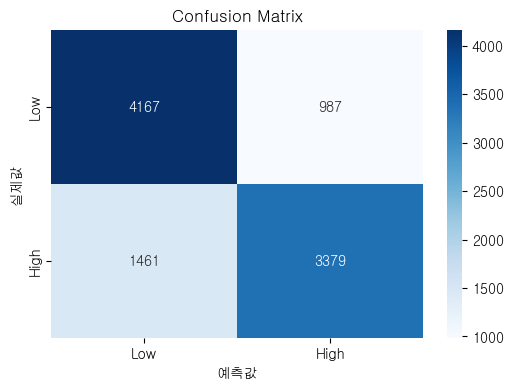

In [33]:
# 혼동 행렬 시각화
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid_binary, y_pred)

# 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.title('Confusion Matrix')
plt.show()

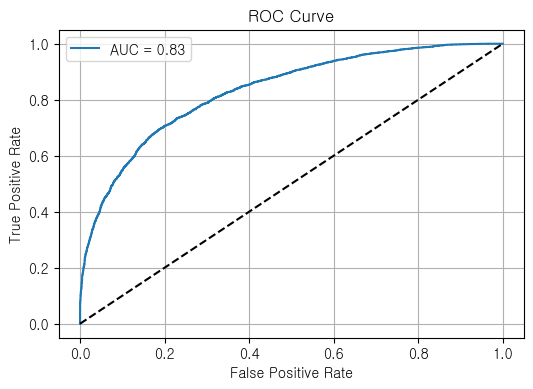

In [34]:
# ROC Curve 
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 확률
y_probs = model.predict_proba(X_valid)[:, 1]

# ROC 커브
fpr, tpr, thresholds = roc_curve(y_valid_binary, y_probs)
auc_score = roc_auc_score(y_valid_binary, y_probs)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\kouls\AppData\Local\Temp\ipykernel_10236\4087850831.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


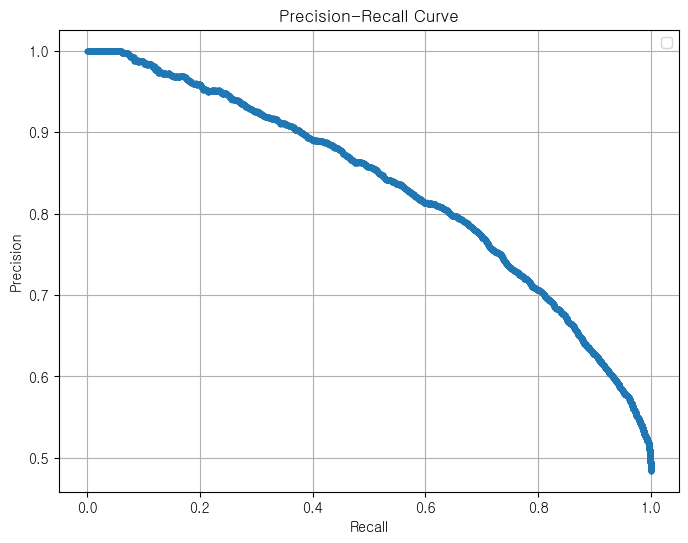

In [35]:
# PR Curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_valid_binary, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()